<a href="https://www.kaggle.com/code/mahyararani/fraudclassification?scriptVersionId=111807087" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 class="list-group-item list-group-item-action active" data-toggle="list" style="color:#241571; background:#B5cae9; border:2px dashed #efe50b;" role="tab" aria-controls="goal"><center></bold>Fraud Classification: An Explotation of Classification Models</center></h1>

![Linear_Regression.jpg](https://www.frbservices.org/binaries/content/gallery/crsocms/news/fed360/070120/fraudclassifier-full.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import preprocessing
from sklearn.impute import SimpleImputer # Imputing missing values
from imblearn.under_sampling import RandomUnderSampler # Class Imbalance

# Numerical features selection
from sklearn.decomposition import PCA 

# Categorical Features Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Classification Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Model validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Model Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics

# Pipeline
from sklearn.pipeline import Pipeline

# Other General Imports
import gc
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

# Data Loading and Reducing the Size

Since the data is big in size, we will use function to reduce its memory for fast processing and consuming less storage.

In [2]:
start = time.time()
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
# loading train_transaction data
tt = pd.read_csv('../input/ieeecis-fraud-detection/train_transaction.csv')
print(tt.shape)
tt = reduce_mem_usage(tt)

# loading train_transaction data
ti = pd.read_csv('../input/ieeecis-fraud-detection/train_identity.csv')
print(ti.shape)
ti = reduce_mem_usage(ti)

train = pd.merge(tt, ti, how = 'left')
print('Train shape',train.shape)

train.head()

del tt, ti

NameError: name 'pd' is not defined

In [ ]:
# loading test_transaction data
ts = pd.read_csv('../input/ieeecis-fraud-detection/test_transaction.csv')
print(ts.shape)
ts = reduce_mem_usage(ts)

tsi = pd.read_csv('../input/ieeecis-fraud-detection/test_identity.csv')
print(tsi.shape)
tsi = reduce_mem_usage(tsi)

test = pd.merge(ts, tsi, how = 'left')
print('Test shape',test.shape)
test.head()

del ts, tsi

# Data Understanding

## Data Exploration

In [ ]:
# Class imbalance check
plt.pie(train.isFraud.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

As one can expect, this is a class imbalance problem. Thus, the accuracy and specifity are not a good criteria to measure the models we want to apply later and we must change the sensitivity in our classification models and change it to 0.35 indstead of 0.5 or apply more novel methods dealing with imbalance dataset. 
We will apply UnderSampling to deal with class imbalance in later steps. Let us understand the distribution of the timestamp column.

### TransactionDT

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train['TransactionDT'], label='Train', bins = 25, color="#005BBB")
plt.hist(test['TransactionDT'], label='Test', bins = 25, color= "#FFD500")
plt.ylabel('Count')
plt.title('Transaction Timestamp')
plt.legend()
plt.tight_layout()
plt.show()

The difference train.min() and test.max() is x = 34214345 - 86400 = 34127945 but we don't know is it in seconds,minutes or hours.

If it is in hours then the dataset timespan will be x/(24*365) = 3895.884132 years which is not possible.

if it is in minutes then the dataset timespan will be x/(60*24*365) = 64.931402 years which is not possible because Vesta Corporation was founded in 1995 so they can have at most 24 years of data.

If it is in seconds then dataset timespan will be x/(3600*24*365) = 1.0821 years which seems reasonable to me.

**Time span of the total dataset is 394.9993634259259 days**

**Time span of Train dataset is  181.99920138888888 days**

**Time span of Test dataset is  182.99908564814814 days**

**The gap between train and test is 30.00107638888889 days**

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionDT'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionDT', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

In [ ]:
i = 'isFraud'
cor = np.corrcoef(train['TransactionDT'], train[i])[0,1]
train.loc[train['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
train.loc[train['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

### Transation Amount

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

### ProductCD Feature

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

### Cards Features

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 4 Distributions', fontsize=18)

plt.subplot(221)
g1 = sns.countplot(x='card4', data=train)
g1 = sns.countplot(x='card4', data=train)
g1.set_title("Card4 Distribution", fontsize=12)
g1.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g2 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g2.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=12)
g2.set_xlabel("Card4 Category Names", fontsize=12)
g2.set_ylabel("Transaction Values", fontsize=12)


In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle('Card 6 Distributions', fontsize=18)

plt.subplot(221)
g = sns.countplot(x='card6', data=train)
g.set_title("Card6 Distribution", fontsize=12)
g.set_ylabel("Count", fontsize=12)

plt.subplot(212)
g1 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', 
              data=train[train['TransactionAmt'] <= 2000] )
g1.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=12)
g1.set_xlabel("Card6 Category Names", fontsize=12)
g1.set_ylabel("Transaction Values", fontsize=12)


In [ ]:
cards = ['card1', 'card2', 'card3', 'card5']

for col in cards:
    fig = plt.figure(figsize = (9,6))
    ax = fig.gca()
    feature = train[col]
    feature.hist(bins = 100, ax=ax)
    ax.axvline(feature.mean(), color = 'magenta', linestyle = 'dashed', linewidth = 2)
    ax.axvline(feature.median(), color= 'cyan', linestyle = 'dashed', linewidth = 2)
    ax.set_title(col)
plt.show()

### Addr1 and Addr2 Features

In [ ]:
print("Card Features Quantiles: ")
print(train[['addr1', 'addr2']].quantile([0.01, 0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975, 0.99]))

### C1-C14 Features

In [ ]:
plt.figure(figsize=(10, 7))
c_features = list(train.columns[16:30])
uniques = [len(train[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### D1-D15 Features

In [ ]:
plt.figure(figsize=(10, 7))
d_features = list(train.columns[30:45])
uniques = [len(train[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### V1-V339 Features

In [ ]:
plt.figure(figsize=(35, 8))
v_features = list(train.columns[54:170])
uniques = [len(train[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Device Type in Train Identity

In [ ]:
ax = sns.countplot(x="DeviceType", data=train)
ax.set_title('DeviceType', fontsize=14)
sns.set(rc={"figure.figsize": (3,4)})
plt.show()

### Device Information in Train Identity

In [ ]:
print ("Unique Devices = ",train['DeviceInfo'].nunique())
train['DeviceInfo'].value_counts().head()

# Data Preparation

In [ ]:
def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [ ]:
summary(train)

In [ ]:
summary(test)

## Feature Engineering 1

### Handling and Genearating Features

In [ ]:
def Devices(df):
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]
    df['device_version'] = df['DeviceInfo'].str.split('/', expand=True)[1]
    df = df.drop(['DeviceInfo'], axis = 1)
    
    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]
    df = df.drop(['id_30'], axis = 1)
    
    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0]
    df['version_id_31'] = df['id_31'].str.split(' ', expand=True)[1]
    df = df.drop(['id_31'], axis = 1)

    df['screen_width'] = df['id_33'].str.split('x', expand=True)[0]
    df['screen_height'] = df['id_33'].str.split('x', expand=True)[1]
    df = df.drop(['id_33'], axis = 1)

    df['id_34'] = df['id_34'].str.split(':', expand=True)[1]
    df['id_23'] = df['id_23'].str.split(':', expand=True)[1]
    df = df.drop(['id_34', 'id_23'], axis = 1)


    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train = Devices(train)

## Dealing with Missing Data

### Identifying the uniqueness of categorical features

In [ ]:
train.drop_duplicates(inplace = True)

We are going to drop the columns with more than 80% missing values baed on [THIS](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8) paper.

Let us now fill all the missing values. For numerical columns, we will use median value and for categorical column, we will use the most frequent category to fill the missing values.

In [ ]:
y = train['isFraud']
TransactionID = train['TransactionID']
TransactionDT = train['TransactionDT']
del test
gc.collect()

In [ ]:
# Dropping columns with more than 80% missing values 
print("Shape before dropping features more than 20% missing values: ", train.shape)
mv = train.isnull().sum()/len(train)
train = train.drop(columns=mv[mv>0.8].index)

print("Shape after dropping features more than 20% missing values: ", train.shape)

In [ ]:
train.dropna(how= 'all', axis = 0)

Based on metadata Categorical Featurs are:

* ProductCD
* emaildomain
* card4 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9
* DeviceType
* DeviceInfo
* id_12 - id_38

However, by filtering the features based on the data type (obj) we have more categorical features.

In [ ]:
train = train.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis = 1)
# Filtering numerical data
num_df = train.select_dtypes(include=np.number)
print(num_df.shape)

# Filtering categorical data
cat_df = train.select_dtypes(exclude=np.number)
print(cat_df.shape)

In [ ]:
num_df.head()

In [ ]:
cat_df.head()

In [ ]:
del train
gc.collect()

In [ ]:
# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_df), columns=num_df.columns)
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
for i in cat_df:
    cat_df[i] = cat_df[i].fillna(cat_df[i].mode()[0])
    
cat_df.isnull().sum()
num_df.isnull().sum()

## Numerical Features

In [ ]:
scaled_num = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(num_df), columns = num_df.columns)
scaled_num.head()

### PCA for Numerical Features

In [ ]:
#optimuadd_suffixm number of components
pca = PCA().fit(scaled_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative Rate of Variance")

In [ ]:
#final
pca = PCA(n_components = 0.95)

pca_fit = pca.fit_transform(scaled_num)
num_pca = pd.DataFrame(data = pca_fit)
pca.explained_variance_ratio_.sum()
del num_df, scaled_num

In [ ]:
num_pca.head()

## Categorical Features

Due to we have too many values in some categories, we try to map them into new categories.

In [ ]:
for x in cat_df.columns:
    #printing unique values
    print(x ,':', len(cat_df[x].unique()))

In [ ]:
cat_df = pd.get_dummies(cat_df)
cat_df.head()

# Tree-based Categorical Feature Selection

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, criterion = 'entropy')
clf = clf.fit(cat_df, y)


In [ ]:
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = cat_df.columns[feature_idx]

cat_new = pd.DataFrame(model.transform(cat_df), columns = feature_name)
cat_new.head()

### Concatenating Numerical and Categorical Features 

In [ ]:
# Concatinating numerical and categorical data
df = pd.concat([y, TransactionID, TransactionDT, num_pca, cat_new], axis=1)
df = pd.DataFrame(df)

# Verifying missing values
print(f'Total missing values: {df.isnull().sum().sum()}')
print(df.shape)
df.head()

In [ ]:
del  cat_new, num_pca, y
gc.collect()

In [ ]:
df = reduce_mem_usage(df)

**This part is only for reducing time work on the clean dataset and apply the models**

In [6]:
df.to_csv('df.csv')

NameError: name 'df' is not defined

In [3]:
df = pd.read_csv('../input/dffraudclassification/df.csv')
df.head()

,Unnamed: 0,isFraud,TransactionID,TransactionDT,0,1,2,3,4,5,...,browser_id_31_firefox,version_id_31_58.0,version_id_31_61.0,version_id_31_62.0,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_66.0,version_id_31_generic,version_id_31_safari
0,0,0,2987000,86400,-0.32370,-0.19540,0.16500,0.42720,0.04540,-0.18640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,2987001,86401,-0.36700,0.27000,0.13180,0.18270,0.67330,-0.02573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0,2987002,86469,-0.07666,-0.15780,-0.19960,0.11945,0.42100,-0.20010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0,2987003,86499,-0.20450,-0.03568,-0.12870,0.85940,-0.01144,-0.22830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0,2987004,86506,-0.39140,-0.13420,-0.10614,0.42360,0.66000,-0.24900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 536.15 MB
Memory usage after optimization is: 136.85 MB
Decreased by 74.5%


### Class Imbalance

We applied udersampling to decrease the modeling time and better identifieying the isFraud target feature.

In [5]:
y = df['isFraud']
X = df.drop(['isFraud', 'Unnamed: 0', 'TransactionID', 'TransactionDT'], axis = 1)
X_array=np.array(X)

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

pd.value_counts(y_resampled)

(41326, 115) (41326,)


0    20663
1    20663
Name: isFraud, dtype: int64

In [6]:
X_df = pd.DataFrame(X_resampled, columns = X.columns)
y_df = pd.DataFrame(y_resampled)
df = pd.concat([X_df, y_df], axis= 1)
df.shape 
df.head()

,0,1,2,3,4,5,6,7,8,9,...,version_id_31_58.0,version_id_31_61.0,version_id_31_62.0,version_id_31_63.0,version_id_31_64.0,version_id_31_65.0,version_id_31_66.0,version_id_31_generic,version_id_31_safari,isFraud
0,-0.087585,-0.374023,-0.381348,-0.146851,0.249146,0.422607,0.472412,-0.136108,0.084229,0.030197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.085205,0.212402,0.074646,-0.298340,-0.146118,-0.240601,0.362305,0.104370,0.147949,-0.101013,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.296143,-0.145020,-0.079163,0.039246,-0.191040,-0.335205,-0.064941,-0.172241,0.087158,-0.037140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,-0.234131,-0.321045,-0.188599,0.011108,-0.262207,-0.213623,0.333496,-0.016357,-0.029160,0.002905,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.185425,-0.368896,0.405518,-0.219482,-0.292969,-0.218750,-0.212280,-0.059814,-0.028717,0.029449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


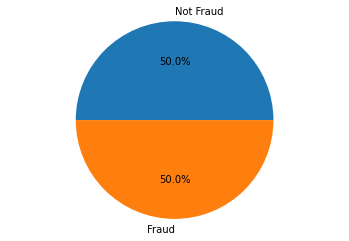

In [7]:
# Class imbalance check
plt.pie(y_df.value_counts(), labels=['Not Fraud', 'Fraud'], autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [8]:
df.shape 

(41326, 116)

In [9]:
del X_df, y_df, X_resampled, y_resampled
gc.collect()

2366

# Modeling

In [10]:
y = df['isFraud']
X = df.drop(['isFraud'], axis = 1)

## Naive Bayes

In [15]:
nb_clf = naive_bayes.BernoulliNB()

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    nb_clf.fit(X_train, y_train)
    y_pred = nb_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.6671 ±0.0021
recall      = 0.6671 ±0.0021
precision   = 0.6889 ±0.0020
f1          = 0.6708 ±0.0020


With GuassianNB the scores are relatively lower.

0.7490827095385915


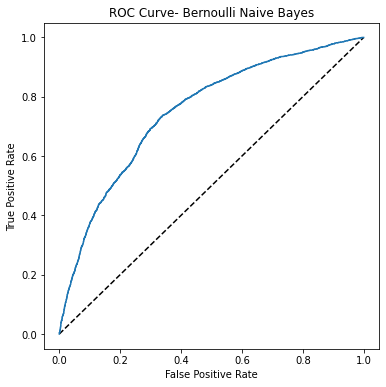

In [16]:
y_scores = nb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
NBScore = metrics.auc(fpr, tpr)
print(NBScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bernoulli Naive Bayes')
plt.show()

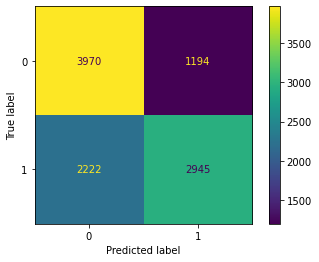

In [17]:
metrics.plot_confusion_matrix(nb_clf, X_test, y_test).ax_.grid(False)

## Logistic Regression

In [19]:

lg_clf = LogisticRegression(solver="liblinear")

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lg_clf.fit(X_train, y_train)
    y_pred = lg_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7524 ±0.0020
recall      = 0.7524 ±0.0020
precision   = 0.7545 ±0.0020
f1          = 0.7527 ±0.0020


0.8346200122717651


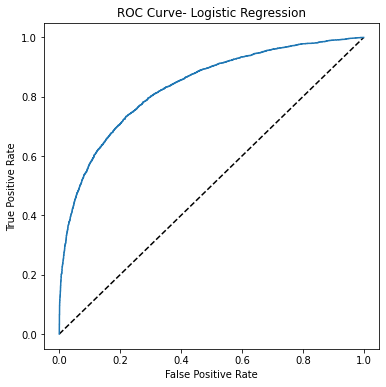

In [20]:
y_scores = lg_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
LGScore = metrics.auc(fpr, tpr)
print(LGScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

## KNN Classifier
### Tuning

Text(0, 0.5, 'Error Rate')

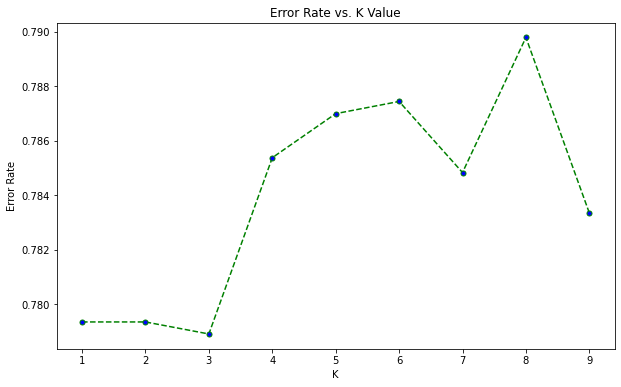

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

error_rate = []
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(metrics.precision_score(y_test, pred_i))

plt.figure(figsize=(10,6))
plt.plot(range(1,10), error_rate,color='g', linestyle='dashed', marker='o', markerfacecolor='b', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [23]:
knn_clf = KNeighborsClassifier(n_neighbors=8, weights='distance')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.8020 ±0.0049
recall      = 0.8020 ±0.0049
precision   = 0.8050 ±0.0051
f1          = 0.8023 ±0.0050


0.8788503675158311


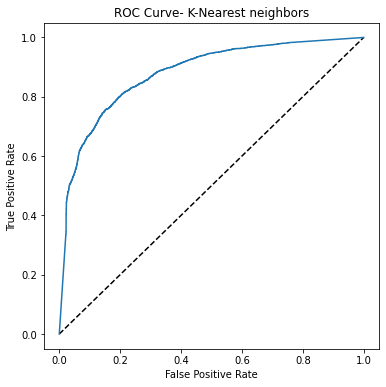

In [24]:
y_scores = knn_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
KNScore = metrics.auc(fpr, tpr)
print(KNScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- K-Nearest neighbors')
plt.show()

## Support Vector Machine (SVM)

In [29]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average="weighted")
rec = metrics.recall_score(y_test, y_pred, average="weighted")
f1 = metrics.f1_score(y_test, y_pred, average="weighted")

print("acc: {:.4f}\nprec: {:.4f}\nrec: {:.4f}\nf1: {:.4f}".format(acc, prec, rec, f1))

KeyboardInterrupt: 

0.7790278366389094


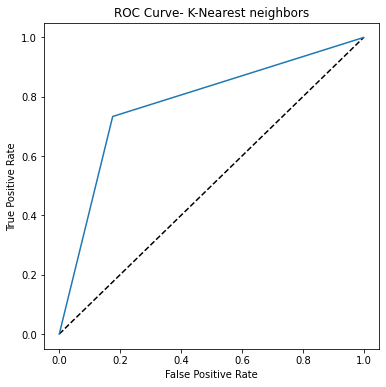

In [26]:
# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
SVScore= metrics.auc(fpr, tpr)
print(SVScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Support Vector Machine')
plt.show()

In [36]:
gc.collect()

16971

## Decision Tree Classifier

In [37]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt_clf.fit(X_train, y_train)
    y_pred = dt_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7406 ±0.0036
recall      = 0.7406 ±0.0036
precision   = 0.7413 ±0.0036
f1          = 0.7407 ±0.0036


0.7392286065250231


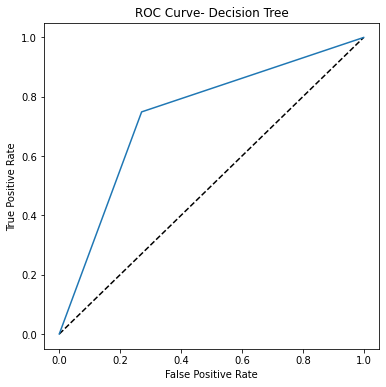

In [38]:
y_scores = dt_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
DTScore = metrics.auc(fpr, tpr)
print(DTScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Decision Tree')
plt.show()

## Random Forest Classifier

In [39]:
rf_clf = RandomForestClassifier(criterion = 'entropy')

kf = KFold(n_splits = 4, shuffle = True, random_state=0)

acc, prec, rec, f1 = [], [], [], []
for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.8273 ±0.0019
recall      = 0.8273 ±0.0019
precision   = 0.8280 ±0.0019
f1          = 0.8273 ±0.0018


0.902502073652478


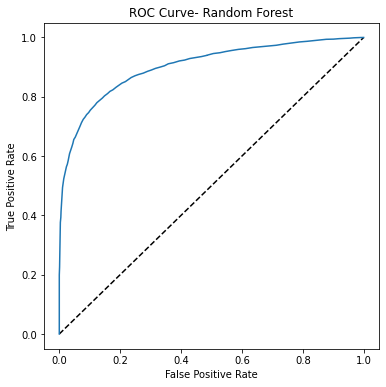

In [40]:
y_scores = rf_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

## MLP Classifier

### Tuning

In [41]:
parameter_space = {
    'max_iter': [500, 1000, 2000],
    'hidden_layer_sizes': [(10, ), (20,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.1, 0.5, 0.9],
}
MLP_clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=2)
MLP_clf.fit(X, y)

GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.001, 0.01, 0.1, 0.5, 0.9],
                         'hidden_layer_sizes': [(10,), (20,)],
                         'max_iter': [500, 1000, 2000]})

In [42]:
print('Best parameters found:\n', MLP_clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (10,), 'max_iter': 500}


In [44]:
kfold = KFold(n_splits =4, shuffle=True, random_state=0)

acc, prec, rec, f1 = [], [], [], []

for train_idx, test_idx in kfold.split(df):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    X_scaler = preprocessing.MinMaxScaler()
    X_train = X_scaler.fit_transform(X_train)
    
    mlp_clf = MLPClassifier(hidden_layer_sizes=(10,),
                            max_iter=500,
                            activation="relu",
                            alpha= 0.5)
        
    
    mlp_clf.fit(X_train, y_train)
    
    y_pred = mlp_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average= 'weighted')]
    prec += [metrics.precision_score(y_pred, y_test, average= 'weighted')]
    f1 += [metrics.f1_score(y_pred, y_test, average= 'weighted')]
    
print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall    = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7428 ±0.0084
recall    = 0.7428 ±0.0084
precision = 0.7746 ±0.0120
f1        = 0.7471 ±0.0060


0.831256182917361


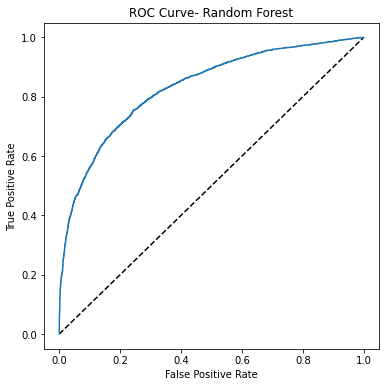

In [45]:
y_scores = mlp_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
MLPScore = metrics.auc(fpr, tpr)
print(MLPScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

## Bagging Classifier

In [46]:
bc_clf = BaggingClassifier()

kf = KFold(n_splits = 4, shuffle = True, random_state =0)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    bc_clf.fit(X_train, y_train)
    y_pred = bc_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]


print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


accuracy    = 0.8016 ±0.0037
recall      = 0.8016 ±0.0037
precision   = 0.8045 ±0.0037
f1          = 0.8019 ±0.0037


0.8730142332088118


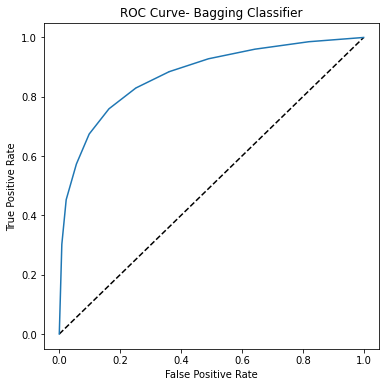

In [47]:
y_scores = bc_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
BCScore = metrics.auc(fpr, tpr)
print(BCScore)


# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Bagging Classifier')
plt.show()

In [ ]:
metrics.plot_confusion_matrix(bc_clf, X_test, y_test).ax_.grid(False)

## Gradient Boosting Classifier
### Tuning

In [48]:
#gb_clf = GradientBoostingClassifier(learning_rate=0.001, max_depth= 8,
#                                    max_features=5, n_estimators= 100, random_state=0)
gb_clf = GradientBoostingClassifier()
kf = KFold(n_splits = 4, shuffle = True)
acc, prec, rec, f1 = [], [], [], []

for train_index, test_index in kf.split(df):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    gb_clf.fit(X_train, y_train)
    y_pred = gb_clf.predict(X_test)
    
    acc += [metrics.accuracy_score(y_pred, y_test)]
    rec += [metrics.recall_score(y_pred, y_test, average="weighted")]
    prec += [metrics.precision_score(y_pred, y_test, average="weighted")]
    f1 += [metrics.f1_score(y_pred, y_test, average="weighted")]

print("accuracy    = {:.4f} ±{:.4f}".format(np.mean(acc), np.std(acc)))
print("recall      = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
print("precision   = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
print("f1          = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

accuracy    = 0.7758 ±0.0016
recall      = 0.7758 ±0.0016
precision   = 0.7782 ±0.0019
f1          = 0.7760 ±0.0016


0.8518213301138158


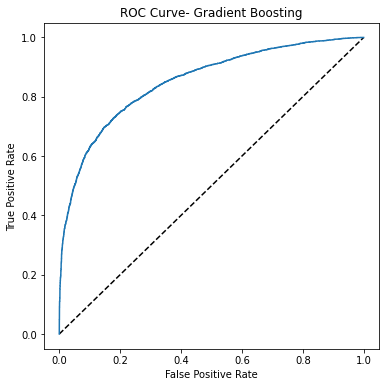

In [49]:
y_scores = gb_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
GBScore = metrics.auc(fpr, tpr)
print(GBScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Gradient Boosting')
plt.show()

# Comparing Models

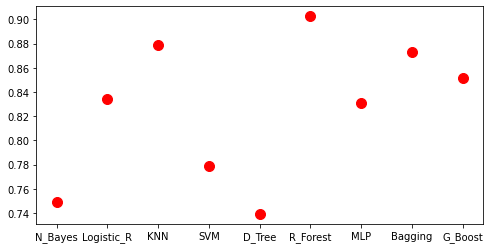

In [50]:
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.plot(['N_Bayes', 'Logistic_R', 'KNN', 'SVM', 'D_Tree', 'R_Forest', 'MLP', 'Bagging', 'G_Boost'],
         [NBScore, LGScore, KNScore, SVScore, DTScore, RFScore, MLPScore, BCScore, GBScore], 'ro', markersize=10)

plt.show()

**We could see Rando Forest Classifier has the higherst average score, now we continue to tune and make it as a pipeline after hyperparameter tuning.**

In [ ]:
print('Time Spent:', time.time() - start)

In [51]:
gc.collect()

19398

## Chosen Model HyperParameters Tuning

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
rf_clf = RandomForestClassifier()


n_estimators = [500, 700, 1000, 1500]
test_results = []
for estimator in n_estimators:
    rf_clf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf_clf.fit(x_train, y_train)    
    y_pred = rf_clf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(8,4))
plt.plot(n_estimators, test_results ,color='g', linestyle='dashed', marker='o', markerfacecolor='b', markersize=5)
plt.title('ROC_AUC Rate Vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('ROC_AUC')

In [ ]:
max_depths = [600, 1200, 1800, 2400]
test_results = []
for depth in max_depths:
    rf_clf = RandomForestClassifier(max_depth=depth, n_jobs=-1)
    rf_clf.fit(x_train, y_train)    
    y_pred = rf_clf.predict(x_test)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize=(8,4))
plt.plot(max_depths, test_results ,color='g', linestyle='dashed', marker='o', markerfacecolor='b', markersize=5)
plt.title('ROC_AUC Rate Vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('ROC_AUC')

**We are going to perform hypertuning parameter by GridSearchCV in narrow ranges, especially focusing in finding the string parameters and then use Randomized GridSearchCV to expand the ranges to find best parameters over in large number of especially max_ddepth and n_estimators**

In [14]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rf = RandomForestClassifier()
param_grid = {'bootstrap': [True, False],
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 20],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 3, 5],
              'min_samples_split': [1, 3, 5],
              'n_estimators': [100, 200, 300]
             }

RF_clf = GridSearchCV(estimator = rf,
                      param_grid = param_grid,
                      scoring = 'roc_auc',
                      cv= 2,
                      verbose=1,
                      n_jobs = -1)

RF_clf.fit(X_train, y_train)
print('Best parameters found:\n', RF_clf.best_params_)

print('Time Spent:', time.time() - start)

Fitting 2 folds for each of 432 candidates, totalling 864 fits


KeyboardInterrupt: 

In [15]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

rf = RandomForestClassifier()
param_grid = {'bootstrap': [True, False],
              'criterion': ['entropy', 'gini'],
              'max_depth': range(10, 300, 10),
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': range(1, 10, 1),
              'min_samples_split': range(1, 10, 1),
              'n_estimators': range(50, 2000, 50)
             }

RF_clf = RandomizedSearchCV(estimator = rf,
                            n_iter = 30,
                            param_distributions = param_grid,
                            scoring = 'roc_auc',
                            cv= 2,
                            verbose=3,
                            n_jobs = -1)

RF_clf.fit(X_train, y_train)
print('Best parameters found:\n', RF_clf.best_params_)

print('Time Spent:', time.time() - start)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=270, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=450;, score=0.884 total time=  47.5s
[CV 1/2] END bootstrap=False, criterion=gini, max_depth=140, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=350;, score=nan total time=   0.3s
[CV 2/2] END bootstrap=False, criterion=gini, max_depth=140, max_features=auto, min_samples_leaf=9, min_samples_split=1, n_estimators=350;, score=nan total time=   0.3s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=280, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300;, score=0.875 total time=  31.1s
[CV 2/2] END bootstrap=True, criterion=entropy, max_depth=270, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1000;, score=0.871 total time= 2.1min
[CV 1/2] END bootstrap=True, criterion=entropy, max_depth=180, max_features=auto, min_s

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler 
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

space = {
    "bootstrap": hp.choice("bootstrap", [True, False]),
    "n_estimators": hp.choice("n_estimators", [400, 500, 600, 800]),
    "max_depth": hp.choice("max_depth", [50, 100, 200]),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "max_features": hp.choice("max_features", ['sqrt', 'auto']),
    "min_samples_leaf": hp.choice ("min_samples_leaf", [1, 3, 5]),
    "min_samples_split": hp.choice("min_samples_split", [2, 3, 4])
    
}

def hyperparameter_tuning(params):
    rf = RandomForestClassifier(**params,n_jobs=-1, verbose = 0)
    rf.fit(X_train, y_train)
    y_scores = rf.predict_proba(X_test)
    roc= metrics.roc_auc_score(y_test, y_scores[:,1])
    return {"loss": -roc, "status": STATUS_OK}


trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=5, 
    trials=trials
)

print("Best: {}".format(best))

In [ ]:
rf_clf = RandomForestClassifier(bootstrap = False, criterion= 'entropy', max_depth= 100, max_features= 'auto',
                                min_samples_leaf= 1, min_samples_split= 2, n_estimators= 500)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
acc = [metrics.accuracy_score(y_pred, y_test)]
rec = [metrics.recall_score(y_pred, y_test, average="weighted")]
prec = [metrics.precision_score(y_pred, y_test, average="weighted")]
f1 = [metrics.f1_score(y_pred, y_test, average="weighted")]
    
print("accuracy    = {:.4f}", acc)
print("recall      = {:.4f}", rec)
print("precision   = {:.4f}", prec)
print("f1          = {:.4f}", f1)

y_scores = rf_clf.predict_proba(X_test)

# calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_scores[:,1])
RFScore = metrics.auc(fpr, tpr)
print(RFScore)

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest Optimized')
plt.show()